In [1]:
import os
import math
import scipy
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
from scipy import interpolate
from scipy.interpolate import Rbf
import seawater as sw
from seawater.library import T90conv
import warnings
warnings.filterwarnings("ignore")
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from numpy import save
from numpy import load
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import regularizers  # 正则化
from tensorflow.keras.layers import Input,Dense,Dropout,Activation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import json
from copy import deepcopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
class PSO():
    def __init__(self,featureNum,featureArea,featureLimit,featureType,particleNum=20,epochMax=10,c1=2,c2=2):
        """
        粒子群算法
        featureNum: 粒子特征数
        featureArea: 特征上下限矩阵
        featureLimit: 特征上下区间的开闭，0为不包含，1为包含
        featureType: 特征类型
        particleNum: 粒子个数
        epochMax: 最大迭代次数
        c1: 自身认知学习因子
        c2: 群体认知学习因子
        """

        self.featureNum = featureNum
        self.featureArea = np.array(featureArea).reshape(featureNum,2)
        self.featureLimit = np.array(featureLimit).reshape(featureNum,2)
        self.featureType = featureType
        self.particleNum = particleNum
        self.epochMax = epochMax
        self.c1 = c1
        self.c2 = c2
        self.epoch = 0        #已迭代次数
        
        #自身最优适应度记录
        self.pBest = [-1e+10 for i in range(particleNum)]
        self.pBestArgs = [None for i in range(particleNum)]
        #全局最优适应度记录
        self.gBest = -1e+10
        self.gBestArgs = None
        
        #初始化所有粒子
        self.particles = [self.initParticle() for i in range(particleNum)]
        #初始化所有粒子的学习速度
        self.vs = [np.random.uniform(0,1,size=featureNum) for i in range(particleNum)]
        
        #迭代历史
        self.gHistory = {"特征%d"%i:[] for i in range(featureNum)}
        self.gHistory["群内平均"] = []
        self.gHistory["全局最优"] = []

    def standardValue(self,value,lowArea,upArea,lowLimit,upLimit,valueType):
        """
        规范一个特征值，使其落在区间内
        value: 特征值
        lowArea: 下限
        upArea: 上限
        lowLimit: 下限开闭区间
        upLimit: 上限开闭区间
        valueType: 特征类型
        return: 修正后的值
        """
        if value < lowArea:
            value = lowArea
        if value > upArea:
            value = upArea
        if valueType is int:
            value = np.round(value,0)

            #下限为闭区间
            if value <= lowArea and lowLimit==0:
                value = lowArea + 1
            #上限为闭区间
            if value >= upArea and upLimit==0:
                value = upArea - 1
        elif valueType is float:
            #下限为闭区间
            if value <= lowArea and lowLimit == 0:
                value = lowArea + 1e-10
            #上限为闭=间
            if value >= upArea and upLimit==0:
                value = upArea - 1e-10
        return value

    def initParticle(self):
        """
        随机初始化1个粒子
        """
        values = []
        #初始化这么多特征数
        for i in range(self.featureNum):
            #该特征的上下限
            lowArea = self.featureArea[i][0]
            upArea = self.featureArea[i][1]
            #该特征的上下阙界
            lowLimit = self.featureLimit[i][0]
            upLimit = self.featureLimit[i][1]
            #随机值
            value = np.random.uniform(0,1) * (upArea-lowArea) + lowArea
            value = self.standardValue(value,lowArea,upArea,lowLimit,upLimit,self.featureType[i])
            values.append(value)
        return values

    def iterate(self,calFitness):
        """
        开始迭代
        calFitness:适应度函数 输入为1个粒子的所有特征和全局最佳适应度，输出为适应度
        """
        while self.epoch<self.epochMax:
            self.epoch += 1
            for i,particle in enumerate(self.particles):
                #该粒子的适应度
                fitness = calFitness(particle,self.gBest)
                #更新该粒子的自身认知最佳方案
                if self.pBest[i] < fitness:
                    self.pBest[i] = fitness
                    self.pBestArgs[i] = deepcopy(particle)
                #更新全局最佳方案
                if self.gBest < fitness:
                    self.gBest = fitness
                    self.gBestArgs = deepcopy(particle)
            #更新粒子
            for i, particle in enumerate(self.particles):
                #更新速度
                self.vs[i] = np.array(self.vs[i]) + self.c1*np.random.uniform(0,1,size=self.featureNum)*(np.array(self.pBestArgs[i])-np.array(self.particles[i])) + self.c2*np.random.uniform(0,1,size=self.featureNum)*(np.array(self.gBestArgs)-np.array(self.particles[i]))
                #更新特征值
                self.particles[i] = np.array(particle) + self.vs[i]
                #规范特征值
                values = []
                for j in range(self.featureNum):
                    #该特征的上下限
                    lowArea = self.featureArea[j][0]
                    upArea = self.featureArea[j][1]
                    #该特征的上下阙界
                    lowLimit = self.featureLimit[j][0]
                    upLimit = self.featureLimit[j][1]
                    #随机值
                    value =self.particles[i][j]
                    value = self.standardValue(value,lowArea,upArea,lowLimit,upLimit,self.featureType[j])
                    values.append(value)
                self.particles[i] = values
            #保存历史数据
            for i in range(self.featureNum):
                self.gHistory["特征%d"%i].append(self.gBestArgs[i])
            self.gHistory["群内平均"].append(np.mean(self.pBest))
            self.gHistory["全局最优"].append(self.gBest)
            print("PSO epoch:%d/%d 群内平均:%.4f 全局最优:%.4f"%(self.epoch,self.epochMax,np.mean(self.pBest),self.gBest))

In [3]:
def calFitness(particle,gBest):
    """
    适应度函数，输入1个粒子的数组和全局最优适应度，返回该粒子对应的适应度
    """
    nodeNum,layers,p = particle#取出粒子的特征值
    PSOmodel,history,testRMSE,testR2 = pso_model(nodeNum,layers,p)
    #该粒子方案超过全局最优
    if testR2>gBest:
        #保存模型和对应信息
        PSOmodel.save("数据/best.h5")
        history = pd.DataFrame(history)
        history.to_excel("数据/best.xlsx",index=None)
        with open("数据/info.json","w") as f:
            f.write(json.dumps({"testRMSE":testRMSE,"testR2":testR2}))
    return testR2

In [4]:
def pso_model(nodeNum,layers,p):
    """
    搭建网络 进行训练，返回模型、训练历史和测试集RMSE,R2
    nodeNum: 网络节点数
    layers:网络层数
    p: dropout概率    
    """
    #输入层
    inputLayer = Input(shape=(6,))
    
    #中间层
    if layers == 1:
        middle1 = Dense(nodeNum,activation='relu')(inputLayer)
        middle = Dropout(p)(middle1)
    if layers == 2:
        middle1 = Dense(nodeNum,activation='relu')(inputLayer)
        middle2 = Dropout(p)(middle1)
        middle = Dense(nodeNum,activation='relu')(middle2)

    if layers == 3:
        middle1 = Dense(nodeNum,activation='relu')(inputLayer)
        middle2 = Dense(nodeNum,activation='relu')(middle1)
        middle3 = Dropout(p)(middle2)
        middle = Dense(nodeNum,activation='relu')(middle3)
    if layers == 4:
        middle1 = Dense(nodeNum,activation='relu')(inputLayer)
        middle2 = Dense(nodeNum,activation='relu')(middle1)
        middle3 = Dense(nodeNum,activation='relu')(middle2)
        middle4 = Dropout(p)(middle3)
        middle = Dense(nodeNum,activation='relu')(middle4)
    
    #输出层
    outputLayer = Dense(1,activation="linear")(middle)

    #构建模型
    model = Model(inputs=inputLayer,outputs=outputLayer)
    model.compile(loss='mse',optimizer='adam')
    
    #训练
    history = model.fit(x_train,y_train,epochs=100,batch_size=1000,verbose=0).history
    
    y_new = model.predict(x_test)
    # 反标准化还原原始量纲
    scaler.fit(y_test_df)
    y_new = scaler.inverse_transform(y_new)
    y_test = pd.DataFrame(y_test_df.values)
    y_new = pd.DataFrame(y_new)
    y = pd.concat([y_test,y_new], axis=1)
    #测试集RMSE,R2
    testRMSE = mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5
    testR2 = r2_score(y.iloc[:,0].values,y.iloc[:,1].values)
    return model,history,testRMSE,testR2

In [2]:
with h5py.File("数据/YINDU_ALL_data.hdf5", 'r') as f:  #‘r’是读取，‘w’是写入
    print(f.keys())
    SSS_all = f.get("SSS_all")[:]
    SST_all = f.get("SST_all")[:]
    PRE_all = f.get("PRE_all")[:]
    SSHA_all = f.get("SSHA_all")[:]
    BLT_all = f.get("BLT_all")[:]
    lat = f.get("lat")[:]
    lon = f.get("lon")[:]

<KeysViewHDF5 ['BLT_all', 'PRE_all', 'SSHA_all', 'SSS_all', 'SST_all', 'lat', 'lon']>


In [3]:
print(lat.shape)
print(lon.shape)
print(SSS_all.shape)
print(SST_all.shape)
print(PRE_all.shape)
print(SSHA_all.shape)
print(BLT_all.shape)

(60,)
(90,)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)


In [4]:
S_x = np.array(SSS_all[:-12,:,:])
T_x = np.array(SST_all[:-12,:,:])
HA_x = np.array(SSHA_all[:-12,:,:])
P_x = np.array(PRE_all[:-12,:,:])
BLT_x = np.maximum(np.array(BLT_all[:-12,:,:]),0)

S_c = np.array(SSS_all[-12:,:,:])
T_c = np.array(SST_all[-12:,:,:])
HA_c = np.array(SSHA_all[-12:,:,:])
P_c = np.array(PRE_all[-12:,:,:])
BLT_c = np.maximum(np.array(BLT_all[-12:,:,:]),0)

In [5]:
xr_SST = xr.open_dataset('数据/NOAA-SST.nc')  #'SST'  00-20
xr_SST_month = xr_SST['SST'][:-1,:,:].resample(TIME="1MS").mean()
SST = xr_SST_month[:-12,:,:]

In [6]:
#经纬度坐标
LON = SST.LON31_120.values
LAT = SST.LAT61_120.values

a = []
for i in range(60):
    a.append(LON)
aa = np.array(a)

b = []
for i in range(90):
    b.append(LAT)
bb = np.array(b).T

In [7]:
S_x_df = pd.DataFrame(S_x.reshape(84,5400)).T
T_x_df = pd.DataFrame(T_x.reshape(84,5400)).T
HA_x_df = pd.DataFrame(HA_x.reshape(84,5400)).T
P_x_df = pd.DataFrame(P_x.reshape(84,5400)).T
BLT_x_df = pd.DataFrame(BLT_x.reshape(84,5400)).T

S_c_df = pd.DataFrame(S_c.reshape(12,5400)).T
T_c_df = pd.DataFrame(T_c.reshape(12,5400)).T
HA_c_df = pd.DataFrame(HA_c.reshape(12,5400)).T
P_c_df = pd.DataFrame(P_c.reshape(12,5400)).T
BLT_c_df = pd.DataFrame(BLT_c.reshape(12,5400)).T

LON_df = pd.DataFrame(aa.reshape(1,5400)).T
LAT_df = pd.DataFrame(bb.reshape(1,5400)).T

In [8]:
train_df = pd.DataFrame()
for i in range(7):
    month = pd.concat([S_x_df.iloc[:, i * 12], T_x_df.iloc[:, i * 12], HA_x_df.iloc[:, i * 12], P_x_df.iloc[:, i * 12],
                       LON_df, LAT_df, BLT_x_df.iloc[:, i * 12]], axis = 1)
    month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
    train_df = pd.concat([train_df, month],axis = 0).dropna()

test_df = pd.concat([S_c_df.iloc[:,0], T_c_df.iloc[:,0], HA_c_df.iloc[:,0], P_c_df.iloc[:,0],
                     LON_df, LAT_df, BLT_c_df.iloc[:,0]], axis = 1).dropna()
test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']


x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
y_train_df = train_df[['BLT']]
x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
y_test_df = test_df[['BLT']]

In [9]:
MARK = x_test_df.index
num = list(range(0,5400,1))
index = [str(x) for x in num]
M = pd.DataFrame([index]).T

MARKarray = np.array(MARK)
MARKt = []
for i in range(7):
    MARKt.append(MARKarray)
MARKtest = np.array(MARKt)
MARKtest = MARKtest.reshape(20734)

In [10]:
x_train_df

,SSS,SST,SSHA,PRE,LON,LAT
2,35.379654,26.346003,0.045350,0.889355,32.5,-29.5
3,35.491821,26.276001,0.068275,0.596452,33.5,-29.5
4,35.522892,26.114002,-0.061375,0.343226,34.5,-29.5
5,35.505867,25.862000,-0.100000,0.274516,35.5,-29.5
6,35.528584,25.567999,0.104975,0.236774,36.5,-29.5
...,...,...,...,...,...,...
4891,36.618168,23.865002,0.135225,0.000000,61.5,24.5
4892,36.620899,24.022501,0.091725,0.000000,62.5,24.5
4893,36.682346,23.975000,0.055450,0.000000,63.5,24.5
4894,36.589848,23.757500,0.113450,0.000000,64.5,24.5


In [11]:
# 训练集标准化
scaler.fit(x_train_df)
x_train = scaler.transform(x_train_df)
scaler.fit(y_train_df)
y_train = scaler.transform(y_train_df)
# 测试集标准化  
scaler.fit(x_test_df)
x_test = scaler.transform(x_test_df)
scaler.fit(y_test_df)
y_test = scaler.transform(y_test_df)

In [ ]:
for i in range(12):
    PSOmodel,History,TestRMSE,TestR2 = pso_model(nodeNum_all[i],layers_all[i],p_all[i])
    PSOmodel.save("数据/bestmodel_"+str(i)+".h5")

In [17]:
#按初始值训练一个神经网络
nodeNum = 64
layers = 2
p = 0.3
PSOmodel,History,TestRMSE,TestR2 = pso_model(nodeNum,layers,p)
PSOmodel.summary()

print("\n节点数:%d 网络层数:%d dropout概率:%.2f 测试集RMSE:%.4f 测试集R2:%.4f"%(nodeNum,layers,p,TestRMSE,TestR2))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________

节点数:64 网络层数:2 dropout概率:0.30 测试集RMSE:4.5287 测试集R2:0.8237


In [211]:
#测试
nodeArea = [32,128]        #节点数区间
layersArea = [2,4]         #隐藏层区间
pArea = [0.2,0.3]            #dropout概率区间

featureNum = 3                                     #3个需要优化的特征
featureArea = [nodeArea,layersArea,pArea]          #3个特征取值范围
featureLimit = [[1,1],[1,1],[0,1]]                 #取值范围的开闭  0为闭区间 1为开区间
featureType = [int,int,float]                      #3个特征的类型

#粒子群算法类
pso = PSO(featureNum,featureArea,featureLimit,featureType)

In [208]:
#开始用粒子群算法寻优
pso.iterate(calFitness)

PSO epoch:1/20 群内平均:0.7761 全局最优:0.8065
PSO epoch:2/20 群内平均:0.7874 全局最优:0.8065
PSO epoch:3/20 群内平均:0.7967 全局最优:0.8065
PSO epoch:4/20 群内平均:0.7981 全局最优:0.8065
PSO epoch:5/20 群内平均:0.7994 全局最优:0.8077
PSO epoch:6/20 群内平均:0.8006 全局最优:0.8077
PSO epoch:7/20 群内平均:0.8024 全局最优:0.8120
PSO epoch:8/20 群内平均:0.8031 全局最优:0.8120
PSO epoch:9/20 群内平均:0.8033 全局最优:0.8120
PSO epoch:10/20 群内平均:0.8034 全局最优:0.8120
PSO epoch:11/20 群内平均:0.8034 全局最优:0.8120
PSO epoch:12/20 群内平均:0.8034 全局最优:0.8120
PSO epoch:13/20 群内平均:0.8034 全局最优:0.8120
PSO epoch:14/20 群内平均:0.8039 全局最优:0.8120
PSO epoch:15/20 群内平均:0.8045 全局最优:0.8120
PSO epoch:16/20 群内平均:0.8045 全局最优:0.8120
PSO epoch:17/20 群内平均:0.8046 全局最优:0.8120
PSO epoch:18/20 群内平均:0.8046 全局最优:0.8120
PSO epoch:19/20 群内平均:0.8047 全局最优:0.8120
PSO epoch:20/20 群内平均:0.8049 全局最优:0.8120


In [21]:
#载入最佳模型和对应的训练历史
bestmodel = load_model("数据/best.h5")
with open("数据/info.json","r") as f:
    info = json.loads(f.read())
bestTestRMSE = float(info["testRMSE"])
bestTestR2 = float(info["testR2"])
bestHistory = pd.read_excel("数据/best.xlsx")
print("最优模型的测试集RMSE:%.4f R2:%.4f"%(bestTestRMSE,bestTestR2))

最优模型的测试集RMSE:3.5224 R2:0.5474


In [214]:
columns = ['每层神经元个数','隐藏层层数','dropout率','群内平均','全局最优','epoch']
history = pd.DataFrame(pso.gHistory)
history["epoch"] = range(1,history.shape[0]+1)
history.columns = columns
history

,每层神经元个数,隐藏层层数,dropout率,群内平均,全局最优,epoch
0,59.0,2.0,0.290255,0.776813,0.801965,1
1,60.0,2.0,0.300000,0.783251,0.811904,2
2,60.0,2.0,0.300000,0.789538,0.811904,3
3,60.0,2.0,0.300000,0.794702,0.811904,4
4,60.0,2.0,0.300000,0.796723,0.811904,5
5,62.0,2.0,0.300000,0.799016,0.814546,6
6,62.0,2.0,0.300000,0.800350,0.814546,7
7,62.0,2.0,0.300000,0.800725,0.814546,8
8,62.0,2.0,0.300000,0.801797,0.814546,9


# 所有月份

In [12]:
hidden_1 = 64
hidden_2 = 128
p = 0.3
model = Sequential()
model.add(Dense(units = hidden_1,
                activation='relu',
                input_shape=(x_train_df.shape[1],)))
model.add(Dropout(p))
model.add(Dense(units = hidden_2,
                activation='relu',
                bias_regularizer=keras.regularizers.l1_l2(0.01)))
model.add(Dense(units = 1,
                activation='linear'))
model.compile(loss='mse',                           # 损失均方误差
              optimizer='adam',                     # 优化器
             )
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
# 保存模型
model.save('model_MLP.h5')  # 生成模型文件 'my_model.h5'
# 加载模型
model = load_model('model_MLP.h5')

pso-ann

In [ ]:
a = np.zeros((1,60,90))
b = np.zeros((1,60,90))
RMSE = []
R2 = []
for j in range(12):
    print('月份:'+str(j+1))
    train_df = pd.DataFrame()
    for i in range(7):
        month = pd.concat([S_x_df.iloc[:, i * 12 + j], T_x_df.iloc[:, i * 12 + j], HA_x_df.iloc[:, i * 12 + j], P_x_df.iloc[:, i * 12 + j],
                           LON_df, LAT_df, BLT_x_df.iloc[:, i * 12 + j]], axis = 1)
        month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
        train_df = pd.concat([train_df, month],axis = 0).dropna()

    test_df = pd.concat([S_c_df.iloc[:,j], T_c_df.iloc[:,j], HA_c_df.iloc[:,j], P_c_df.iloc[:,j],
                         LON_df, LAT_df, BLT_c_df.iloc[:,j]], axis = 1).dropna()
    test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']


    x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_train_df = train_df[['BLT']]
    x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_test_df = test_df[['BLT']]

    # 训练集标准化  
    scaler.fit(x_train_df)
    x_train = scaler.transform(x_train_df)
    scaler.fit(y_train_df)
    y_train = scaler.transform(y_train_df)
    # 测试集标准化  
    scaler.fit(x_test_df)
    x_test = scaler.transform(x_test_df)
    scaler.fit(y_test_df)
    y_test = scaler.transform(y_test_df)
    
    #划分80/20
    np.random.shuffle(train)
    x_train = data[:len(train)*0.8]
    x_val = data[len(train)*0.8:]
    y_train = data[:len(train)*0.8]
    y_val = data[len(train)*0.8:]
    
    bestmodel = load_model("数据/bestmodel_"+str(i)+".h5")
    history = bestmodel.fit(x_train, y_train, epochs=20,batch_size=500,verbose=0,validation_data = (x_val,y_val))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MSE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.ylim(ymin = 0, ymax = 0.04)
    plt.show()
    
    y_new = bestmodel.predict(x_test)
    # 反归一化还原原始量纲
    scaler.fit(y_test_df)
    y_new = scaler.inverse_transform(y_new)

    y_test = pd.DataFrame(y_test_df.values)
    y_new = pd.DataFrame(y_new)
    y = pd.concat([y_test,y_new], axis=1)
    print(str(j+1)+'月 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
    print(str(j+1)+'月 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

    y_new.index = y_test_df.index
    Y = pd.concat([y_test_df,y_new,M],axis=1)
    BLT = np.array(Y.iloc[:,0].T).reshape(1,60,90)
    BLTpred =  np.array(Y.iloc[:,1].T).reshape(1,60,90)
    
    a = np.concatenate((a,BLT),0)
    b = np.concatenate((b,BLTpred),0)
    RMSE.append(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5)
    R2.append(r2_score(y.iloc[:,0].values,y.iloc[:,1].values))
    
    fig = plt.figure(figsize=(8,6))
    font = {'family':'Times New Roman'}
    plt.plot(history.history['loss'],linewidth=2,marker='o',markersize=5)
    plt.plot(history.history['val_loss'],linewidth=2,marker='o',markersize=5)
    plt.title('(a) Best Test Performance at epoch 7',fontsize=20,fontdict=font)
    plt.ylabel('loss',fontsize=20,fontdict=font)
    plt.xlabel('10 Epochs',fontsize=20,fontdict=font)
    plt.xticks([0,2,4,6,8],[1,3,5,7,9],fontproperties='Times New Roman')
    plt.yticks(fontproperties='Times New Roman')
    plt.tick_params(labelsize=15)
    font3 = {'family':'Times New Roman','size':14}
    plt.legend(['Training', 'Validation'],loc='upper right',prop=font3)
    plt.grid(linewidth=1,alpha=0.7,linestyle='--')
    plt.savefig('图epoch.png')
    plt.show()

In [ ]:
bar = [[0,15,30,45,60],[0,15,30,45,60],[0,10,20,30,40],[0,10,20,30,40],[0,10,20,30,40],[0,15,30,45,60],[0,15,30,45,60],[0,25,50,75,100],[0,20,40,60,80],[0,15,30,45,60],[0,15,30,45,60],[0,15,30,45,60]]
for j in range(12):
    lat = np.arange(-30,30)
    lon = np.arange(30,120)
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(14, 7))

    font2 = {'family' : 'Times New Roman',
    'weight' : 'bold',
    'size'   : 30,
    }

    
    ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
    real = ax1.contourf(lon,lat,a[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax1.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month Argo-BLT',font2,fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')

    ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
    pre = ax2.contourf(lon,lat,b[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax2.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month ANN-BLT',font2, fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')
    plt.text(92,25,'MSE='+str(round(RMSE[j],3)),fontsize='15')
    plt.text(92,20,'R$^2$ = '+str(round(R2[j],3)),fontsize='15')
    plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11
2,3.030303,0.202020,1.616162,0.808081,1.515152,4.797980,9.848485,4.545455,1.262626,0.808081,2.020202,0.303030
3,3.232323,0.202020,1.414141,1.010101,1.515152,5.050505,9.040404,3.787879,1.767677,0.606061,2.020202,0.606061
4,3.333333,0.202020,1.414141,1.010101,1.515152,5.050505,8.888889,3.030303,2.424242,0.404040,2.020202,0.404040
5,3.232323,0.202020,1.212121,1.010101,1.010101,5.303030,8.636364,4.040404,2.626263,0.404040,2.020202,0.202020
6,2.727273,0.202020,1.212121,1.010101,1.010101,5.050505,7.424242,4.292929,2.424242,0.404040,1.616162,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4891,0.000000,3.535354,3.838384,0.000000,0.505051,0.000000,0.000000,0.000000,0.000000,0.606061,0.000000,0.000000
4892,0.000000,3.535354,3.030303,0.000000,0.505051,0.000000,0.000000,0.000000,0.000000,0.606061,0.000000,0.000000
4893,0.000000,3.535354,1.919192,0.000000,0.404040,0.000000,0.000000,0.000000,0.000000,0.404040,0.000000,0.000000
4894,0.000000,3.787879,0.808081,0.000000,0.404040,0.000000,0.000000,0.000000,0.000000,0.101010,0.000000,0.000000


In [27]:
yuetrue = pd.DataFrame(np.transpose(a[1:,:,:].reshape(12,5400))).dropna()
yuepred = pd.DataFrame(np.transpose(b[1:,:,:].reshape(12,5400))).dropna()
true = np.array(yuetrue)
pred = np.array(yuepred)
#保存为npy文件
from numpy import save
save('yuetrue.npy',true)
save('yuepred.npy',pred)

In [ ]:
true = load('yuetrue.npy')
BLT = load('yuetrue.npy')

月平均 RMSE : 1.796
月平均 R^2 : 0.850


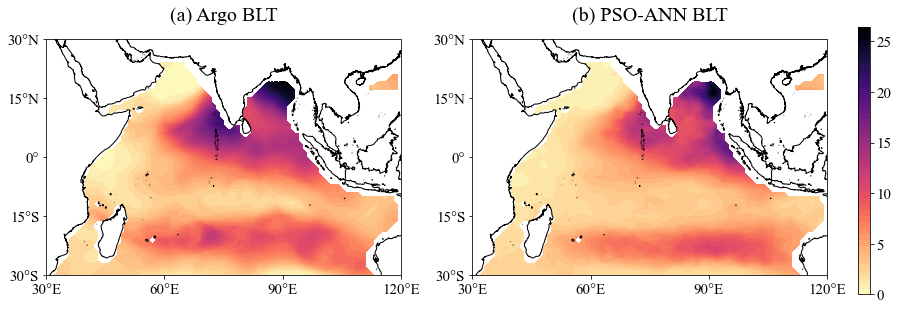

In [56]:
aa = np.nanmean(a[1:,:,:],axis=0).reshape(5400)
bb = np.nanmean(b[1:,:,:],axis=0).reshape(5400)
aa = pd.DataFrame(aa)
bb = pd.DataFrame(bb)
y = pd.concat([aa,bb], axis=1).dropna()
print('月平均 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
print('月平均 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))
font = {'family':'Times New Roman'}

ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
real = ax1.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('magma_r'))
ax1.coastlines("10m")
plt.tick_params(labelsize=15)
ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(a) Argo BLT',font,fontsize=20,y=1.05)
plt.grid(linestyle='-.')

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
pre = ax2.contourf(lon,lat,np.nanmean(b[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('magma_r'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(b) PSO-ANN BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')

cbar_ax = fig.add_axes([0.93, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(real, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0,5,10,15,20,25,30])
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('图预测结果.png')
plt.show()

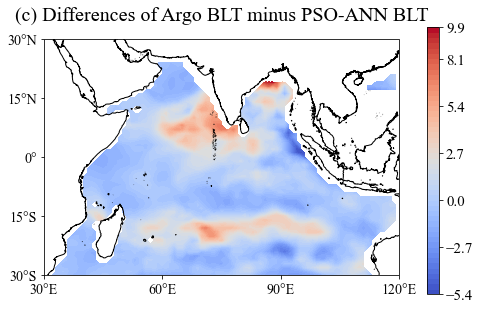

In [53]:
lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 30}

ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
real = ax1.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0)-np.nanmean(b[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('coolwarm'))
plt.title('(c) Differences of Argo BLT minus PSO-ANN BLT',font,fontsize=20,y=1.05)
ax1.coastlines("10m")
plt.tick_params(labelsize=14)
ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.505, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(real, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([-5.4,-2.7,0,2.7,5.4,8.1,float(f"{cbar.vmax:.2f}")])
plt.savefig('pso-ann差异图.png')
plt.show()

In [23]:
true = np.array(y.iloc[:,0])
pred = np.array(y.iloc[:,1])
#保存为npy文件
from numpy import save
save('true.npy',true)
save('pred.npy',pred)

In [15]:
#读取npy文件
from numpy import load
true = load('true.npy')
pred = load('pred.npy')

In [41]:
#读取npy文件
from numpy import load
BLT = load('CMIP6_data.npy')
BLT = pd.DataFrame(np.nanmean(BLT,0))
BLT = BLT.fillna(999)
BLT = np.array(BLT)
BLT = np.where(BLT < 0, np.full_like(BLT,0), BLT)
BLT = np.where(BLT > 900, np.full_like(BLT,None), BLT)

三个区域

the Southeast Arabian Sea (4°N–14°N, 64°E–77°E)

the BoB (7°N–20°N, 79°E–96°E)

the EEIO (5°S–6°N, 79°E–101°E)

In [24]:
#计算RMSE和R2
rmse_all = []
r2_all = []
aaa = a[1:,:,:].reshape(12,5400)
bbb = b[1:,:,:].reshape(12,5400)
for i in range(5400):
    true = aaa[:,i]
    pred = bbb[:,i]
    if np.isnan(true).any() == False:
        rmse = mean_squared_error(true,pred) ** 0.5
        r2 = r2_score(true,pred)
    else:
        rmse = None
        r2 = None
    rmse_all.append(rmse)
    r2_all.append(r2)

In [25]:
rmse_mean = np.array(rmse_all).reshape(60,90)
r2_mean = np.array(r2_all).reshape(60,90)

In [26]:
r2_mean = pd.DataFrame(r2_mean)

In [27]:
r2_mean = r2_mean.fillna(999)

In [28]:
r2_mean = np.array(r2_mean)

In [29]:
r2 = np.maximum(r2_mean,0)
print(r2)

[[9.99000000e+02 9.99000000e+02 5.42833476e-01 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]
 [9.99000000e+02 9.99000000e+02 9.99000000e+02 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]
 [9.99000000e+02 9.99000000e+02 9.99000000e+02 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]
 ...
 [9.99000000e+02 9.99000000e+02 9.99000000e+02 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]
 [9.99000000e+02 9.99000000e+02 9.99000000e+02 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]
 [9.99000000e+02 9.99000000e+02 9.99000000e+02 ... 9.99000000e+02
  9.99000000e+02 9.99000000e+02]]


In [30]:
r2_mean = np.where(r2 > 900, np.full_like(r2,None), r2)

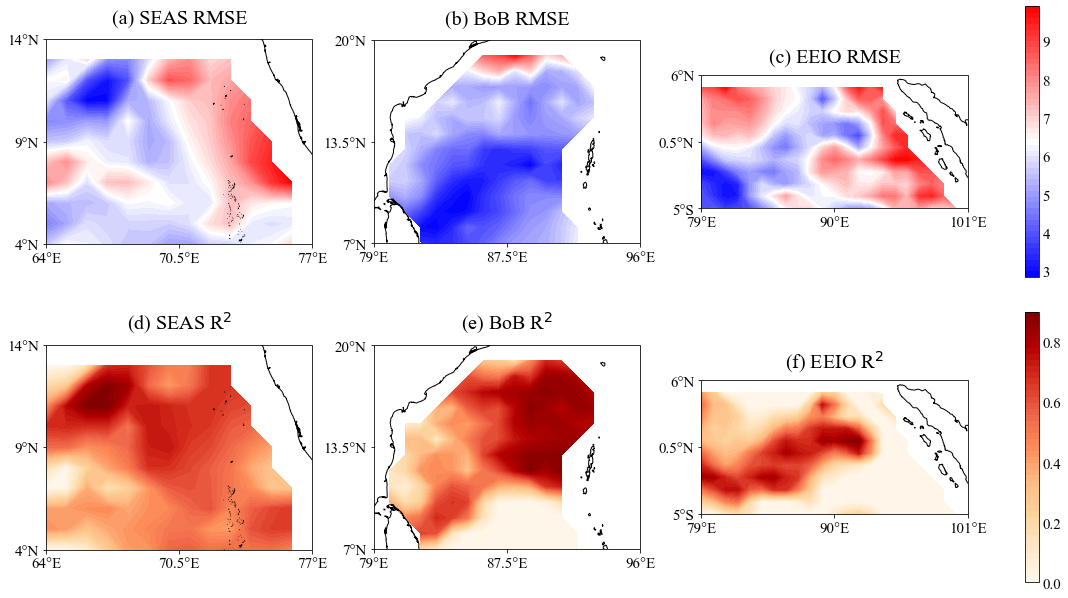

In [39]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20, 10))
font2 = {'family' : 'Times New Roman',
'size'   : 20}

lat = np.arange(4,14)
lon = np.arange(64,77)
ax1 =  fig.add_subplot(2, 3, 1, projection=proj)
t1 = ax1.contourf(lon,lat,rmse_mean[34:44,34:47],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('bwr'))
ax1.coastlines("10m")
plt.tick_params(labelsize=15)
ax1.set_xticks([64,70.5,77], crs=ccrs.PlateCarree())
ax1.set_yticks([4,9,14], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")
plt.title('(a) SEAS RMSE',font2,y=1.05)
plt.grid(linestyle='-.')

ax2 =  fig.add_subplot(2, 3, 4, projection=proj)
t2 = ax2.contourf(lon,lat,r2_mean[34:44,34:47],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('OrRd'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([64,70.5,77], crs=ccrs.PlateCarree())
ax2.set_yticks([4,9,14], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(d) SEAS R$^2$',font2,y=1.05)
plt.grid(linestyle='-.')

lat = np.arange(7,20)
lon = np.arange(79,96)
ax3 =  fig.add_subplot(2, 3, 2, projection=proj)
t3 = ax3.contourf(lon,lat,rmse_mean[37:50,49:66],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('bwr'))
ax3.coastlines("10m")
plt.tick_params(labelsize=15)
ax3.set_xticks([79,87.5,96], crs=ccrs.PlateCarree())
ax3.set_yticks([7,13.5,20], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
for tick in ax3.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax3.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(b) BoB RMSE',font2,y=1.05)
plt.grid(linestyle='-.')

ax4 =  fig.add_subplot(2, 3, 5, projection=proj)
t4 = ax4.contourf(lon,lat,r2_mean[37:50,49:66],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('OrRd'))
ax4.coastlines("10m")
plt.tick_params(labelsize=15)
ax4.set_xticks([79,87.5,96], crs=ccrs.PlateCarree())
ax4.set_yticks([7,13.5,20], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
for tick in ax4.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax4.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(e) BoB R$^2$',font2,y=1.05)
plt.grid(linestyle='-.')

lat = np.arange(-5,6)
lon = np.arange(79,101)
ax5 =  fig.add_subplot(2, 3, 3, projection=proj)
t5 = ax5.contourf(lon,lat,rmse_mean[25:36,49:71],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('bwr'))
ax5.coastlines("10m")
plt.tick_params(labelsize=15)
ax5.set_xticks([79,90,101], crs=ccrs.PlateCarree())
ax5.set_yticks([-5,0.5,6], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
for tick in ax5.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax5.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(c) EEIO RMSE',font2,y=1.05)
plt.grid(linestyle='-.')

ax6 =  fig.add_subplot(2, 3, 6, projection=proj)
t6 = ax6.contourf(lon,lat,r2_mean[25:36,49:71],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('OrRd'))
ax6.coastlines("10m")
plt.tick_params(labelsize=15)
ax6.set_xticks([79,90,101], crs=ccrs.PlateCarree())
ax6.set_yticks([-5,0.5,6], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
for tick in ax6.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax6.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(f) EEIO R$^2$',font2,y=1.05)
plt.grid(linestyle='-.')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.13)

cbar1 = fig.colorbar(t1,ax=[ax1,ax3,ax5])
cbar1.ax.tick_params(labelsize=15)
cbar1.set_ticks([3,4,5,6,7,8,9])
cbar1.ax.tick_params(length=0)

cbar2 = fig.colorbar(t2,ax=[ax2,ax4,ax6])
cbar2.ax.tick_params(labelsize=15)
cbar2.set_ticks([0,0.2,0.4,0.6,0.8,1])
cbar2.ax.tick_params(length=0)

plt.savefig('图3区域.png')
plt.show()

相关性分析

In [2]:
def multipl(a,b):    #传入的是两个序列，传出的是这两个序列的乘积之和。
    sumofab=0.0
    for i in range(len(a)):
        temp=a[i]*b[i]
        sumofab+=temp
    return sumofab

def corrcoef(x,y):    #传入的是两个序列，传出的是两个序列的相关系数。
    n=len(x)
    #求和
    sum1=sum(x)
    sum2=sum(y)
    #求乘积之和
    sumofxy=multipl(x,y)
    #求平方和
    sumofx2 = sum([pow(i,2) for i in x])
    sumofy2 = sum([pow(j,2) for j in y])
    num=sumofxy-(float(sum1)*float(sum2)/n)
    #计算皮尔逊相关系数
    den=math.sqrt((sumofx2-float(sum1**2)/n)*(sumofy2-float(sum2**2)/n))
    return num/den

In [12]:
SSS_pearson=[]
SST_pearson=[]
SSHA_pearson=[]
PRE_pearson=[]
for j in range(12):
    train_df = pd.DataFrame()
    for i in range(7):
        month = pd.concat([S_x_df.iloc[:, i * 12 + j], T_x_df.iloc[:, i * 12 + j], HA_x_df.iloc[:, i * 12 + j], P_x_df.iloc[:, i * 12 + j],
                           LON_df, LAT_df, BLT_x_df.iloc[:, i * 12 + j]], axis = 1)
        month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
        train_df = pd.concat([train_df, month],axis = 0).dropna()

    test_df = pd.concat([S_c_df.iloc[:,j], T_c_df.iloc[:,j], HA_c_df.iloc[:,j], P_c_df.iloc[:,j],
                         LON_df, LAT_df, BLT_c_df.iloc[:,j]], axis = 1).dropna()
    test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']

    x_train_df = np.array(train_df[['SSS','SST','SSHA','PRE','LON','LAT']])
    y_train_df = np.array(train_df[['BLT']])
    x_test_df = np.array(test_df[['SSS','SST','SSHA','PRE','LON','LAT']])
    y_test_df = np.array(test_df[['BLT']])
    
    sss_pearson = corrcoef(x_train_df[:,0],y_train_df)
    sst_pearson = corrcoef(x_train_df[:,1],y_train_df)
    ssha_pearson = corrcoef(x_train_df[:,2],y_train_df)
    pre_pearson = corrcoef(x_train_df[:,3],y_train_df)

    SSS_pearson.append(sss_pearson)
    SST_pearson.append(sst_pearson)
    SSHA_pearson.append(ssha_pearson)
    PRE_pearson.append(pre_pearson)

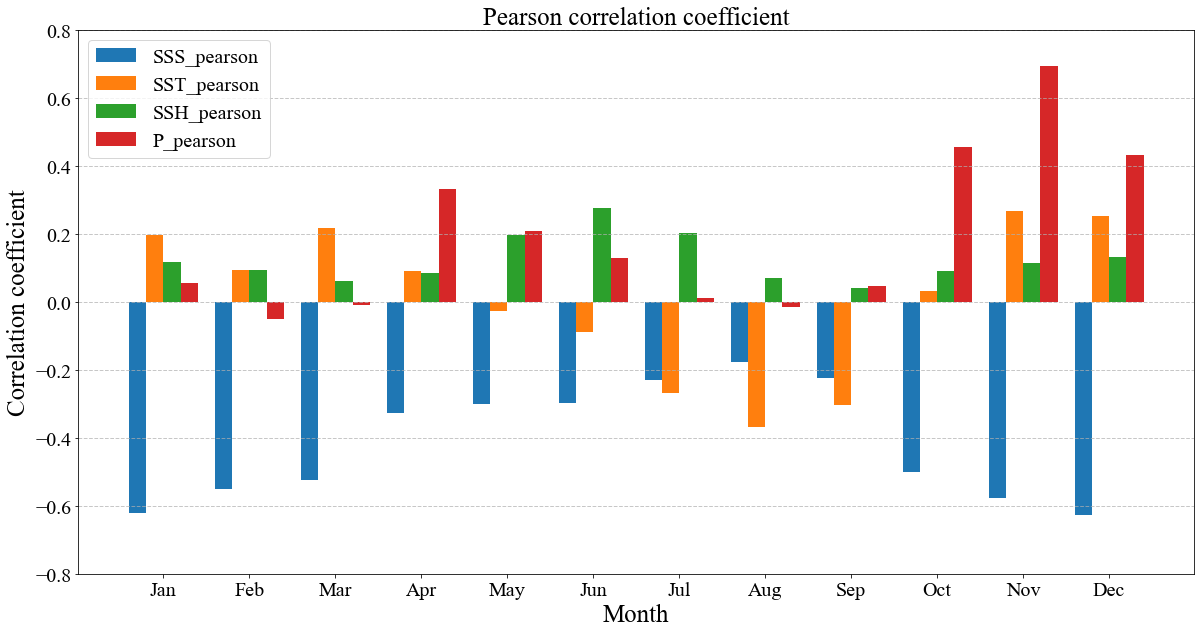

In [19]:
fig = plt.figure(figsize=(20, 10))
width=0.2
font = {'family':'Times New Roman'}
font3 = {'family':'Times New Roman','size':20}
plt.bar([i for i in range(len(SSS_pearson))], list(np.array(SSS_pearson).reshape(12,)), width=width, label='SSS_pearson')
plt.bar([i+width for i in range(len(SST_pearson))], list(np.array(SST_pearson).reshape(12,)), width=width, label='SST_pearson')
plt.bar([i+2*width for i in range(len(SSHA_pearson))], list(np.array(SSHA_pearson).reshape(12,)), width=width, label='SSH_pearson')
plt.bar([i+3*width for i in range(len(PRE_pearson))], list(np.array(PRE_pearson).reshape(12,)), width=width, label='P_pearson')
plt.title('Pearson correlation coefficient',fontsize=25,fontdict=font)
plt.ylabel('Correlation coefficient',fontsize=25,fontdict=font)
plt.xlabel('Month',fontsize=25,fontdict=font)
plt.xticks([x+3*width/2 for x in range(12)],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontproperties='Times New Roman')
plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8],fontproperties='Times New Roman')
plt.tick_params(labelsize=20)
plt.grid(linewidth=1,alpha=0.7,linestyle='--',axis='y')
plt.legend(prop=font3)
plt.savefig('图相关系数.png')
plt.show()

In [123]:
pso_ann_loss = np.concatenate([np.array(RMSE).reshape(1,12),np.array(R2).reshape(1,12)],axis=0)

In [124]:
pso_ann_loss

array([[4.36515502, 5.30761399, 3.74518265, 3.08648744, 3.32640776,
        3.40691859, 4.3307781 , 6.26664998, 5.54302036, 4.52902291,
        4.48220449, 5.23754193],
       [0.83624832, 0.77600475, 0.4883597 , 0.28128761, 0.34374261,
        0.49244282, 0.66344682, 0.59474567, 0.35740787, 0.50669271,
        0.61274357, 0.67948104]])

In [125]:
#保存为npy文件
from numpy import save
save('pso_ann_loss.npy',pso_ann_loss)